<a href="https://colab.research.google.com/github/borisenko-ru/ds_projects/blob/main/04_Gas_Production_Forecasting/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Моделирование дебита газовых скважин с применением машинного обучения на основе данных добычи в Северном море
I.	Введение\
Нефтегазовая отрасль с самого начала своего существования сталкивается с задачами автоматизации и оптимизации. Новейшие технологии и применение алгоритмов на основе данных дали существенный толчок в развитии отрасли в последние годы. В наши дни методы машинного обучения применяются в бурении (Noshi, 2019, Marana и др., 2010), геологии (Tandon, 2019,  Anifowose и др., 2013), петрофизике (Vallabhaneni и др., 2019), добыче (Pennel и др., 2018) и заканчивании скважин (Castiniera и др., 2018, Dan Fu, 2019).\
Современные вычислительные мощности также делают более доступными применение нейросетей и методов глубокого обучения для решения проблем отрасли. Многочисленные исследования показывают различные техники и подходы к решению задач по анализу данных добычи нефти и газа (Rastogi и др., 2019), интерпретации сейсмических данных (Lowell и Paton, 2018) и многих других.\
В общем случае применение методов машинного обучения в отрасли подразделяется на две категории (Mohaghegh, 2019). Первая категория относится к показателям добычи нефти, дебитам нефтяных и газовых скважин. Вторая категория оперирует большим набором характеристик залегающих пластов, получаемых как при проведении обработок, так и при исследованиях скважин с применением различного инструментария. Данная работа основана на первой категории и представляет моделирование дебита газовых скважин с применением машинного обучения на основе открытых данных о добыче группы газовых залежей Viking (Великобритания), разрабатываемых американской транснациональной компанией ConocoPhilips в Северном море.\
В области нефтегазового инжиниринга одна из основных задач специалиста по оценке пласта – точный расчет потенциала работы продуктивного коллектора, его способности отдавать содержащиеся в нем углеводороды. Данный расчет, как правило, выполняется с помощью анализа КПД (кривых падения добычи), которые характеризуют зависимости текущего отбора нефти от фактора времени. Иными словами, кривые падения характеризуют изменение добычи нефти во времени. В результате анализа строится прогноз добычи на будущие периоды, что в дальнейшем используется при оценке запасов углеводородов в государственных органах по рациональному недропользованию.\
С ростом количества внедряемых решений на основе машинного обучения в отрасли возникла необходимость применения имеющихся инструментов и алгоритмов для совершенствования анализа КПД. Одной из причин применения машинного обучения является рост количества данных, получаемых с месторождений и помогающих строить модели продуктивных пластов, а также проводить сопоставление данных моделирования с историческими данными. Традиционные методы анализа КПД энергоемки и ресурсозатратны, что делает новые подходы актуальными.\
В данной работе показано применение алгоритмов ARIMA, Facebook Prophet и XGBoost. Однако, в целом данное исследование не ограничивается вышеуказанными инструментами, и для дальнейшего развития вопроса могут применяться рекуррентные нейронные сети, в том числе LSTM (Sun и др., 2018), зарекомендовавшие себя со стороны высокой точности прогнозирования.\
\
II.	Обзор литературы\
Анализ данных по кривой падения добычи является традиционным отраслевым инструментом для определения производительности продуктивного пласта. Основные методы анализа используют эмпирические модели для прогноза добычи (Arps, 1945, Ilk и др., 2008, Duong, 2010). Многочисленные исторические данные по добыче выделяют несколько отраслевых методов, среди которых метод Арпса, применяемый при возможном отсутствии параметров пласта и без непосредственного определения коэффициента извлечения углеводородов, является наиболее универсальным и широко применяемым инструментом.\ 
В современной литературе представлены работы, описывающие как применение некоторых методов машинного обучения (нейронные сети и глубокое обучение) помогают совершенствовать прогнозные расчеты в сравнении с традиционными методиками (Q.Cao и др., 2016, D.Han и др., 2019, Y.Li и Y.Han, 2017). Алгоритм случайного леса, метод опорных векторов (SVM), многомерные адаптивные регрессионные сплайны (MARS) также во многом способствовали совершенствованию качества прогнозных моделей (Vyas, 2017). Часть исследователей показывают лучшие результаты с применением нейронных сетей, в частности для предсказания дебита нефтяных скважин сланцевых месторождений (Suhag, 2017).\
\
Для проведения экспериментальной части работы использованы открытые данные по ежедневной добыче нефтегазовых месторождений Великобритании, опубликованные компанией Oil and Gas Authority.

In [ ]:
!pip install statsmodels
!pip install fbprophet

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from datetime import timedelta
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from xgboost import XGBRegressor


In [ ]:
class Plots():
  """Класс для отрисовки графиков, используемых в проекте.
  """
  
  def wells(data):
    """Функция для построения графиков добычи из скважин.
    """

    for well in wells:
      data_well = data[data['WELLNAME'] == well].reset_index()
      data_well.plot('DAYTIME', 'ALLOC_GAS_VOL_SM3', kind = 'scatter', s=0.1, title = well)
      plt.show()

  def forecast_plot(actual, forecast, predict_period):
    """Функция для построения графика истинных и прогнозных значений.
    """
  
    predict_start = forecast.index[-predict_period]
    predict_end = forecast.index[-1]

    plt.figure(figsize=(12, 4))
    plt.plot(forecast, color='navy', label='forecast', linewidth=1)
    plt.plot(actual, color='forestgreen', label='actual', linewidth=1)
    plt.legend()
    plt.axvspan(predict_start, predict_end, alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.xlim(pd.Timestamp(forecast.index[0].year, 1, 1), pd.Timestamp(forecast.index[-1].year+1, 1, 1))

  def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """Функция для построения графиков анализа временных рядов.
    """
    
    if not isinstance(y, pd.Series):
      y = pd.Series(y)
    with plt.style.context(style):    
      fig = plt.figure(figsize=figsize)
      layout = (2, 2)
      ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
      acf_ax = plt.subplot2grid(layout, (1, 0))
      pacf_ax = plt.subplot2grid(layout, (1, 1))
      acf_ax.set_xlabel('Lag (days)')
      pacf_ax.set_xlabel('Lag (days)')
      
      y.plot(ax=ts_ax)
      ts_ax.set_title('Time Series Analysis Plots')
      smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
      smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

      print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

      plt.tight_layout()
    return

  def seasonal_decomposition(data):
    """Функция для построения графиков декомпозиции.
    """
    
    decomposed = seasonal_decompose(data) 
    plt.figure(figsize=(6, 8))
    plt.subplot(311)

    # Чтобы график корректно отобразился, указываем его
    # оси ax, равными plt.gca() (англ. get current axis,
    # получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

  def boxplot(data, error):
    """Функция для оценки ошибок МАЕ и MAPE применительно к временным рядам 
    воспользуемся методикой, изложенной в статье (Jiang и Hu, 2018), 
    выделив распределение ошибки по месяцам года с помощью диаграммы 
    разброса.
    """
    
    years = data.index.year.unique().tolist()
    months = range(1, 13)
    
    error_per_year = pd.DataFrame(index=months)
    for year in years:
      error_per_month = {}
      for month in months:
        data_error = data[
                          (data.index.year == year) & 
                          (data.index.month == month) &
                          (data['actual'] != 0) & 
                          (data['forecast'] != 0)
                          ]
        if data_error.shape[0] != 0:
          error_per_month[month] = round(error(data_error['actual'], data_error['forecast']), 1)
        else:
          error_per_month[month] = np.nan
          pass
   
      error_per_year[year] = pd.DataFrame.from_dict(error_per_month, orient='index', columns=[year])

    error_per_year.plot(kind='box', figsize=(12, 4), logy=True, ylabel='Monthly error, %')
    error_mean = round(error_per_year.median().mean(), 2)
    print('Среднее значение ежемесячной ошибки по годам: {}'.format(error_mean))
    pd.Series({1: error_mean, len(error_per_year.columns): error_mean}).plot.line(linestyle='--', color='r')

  def results():
    """Функция для построения графиков результатов анализа временных рядов.
    """

    plt.figure(figsize=(12, 6))
    plt.plot(df_fc_arima['actual'], 'D', label='Actual', markersize=3)
    plt.plot(df_fc_arima['forecast'], color='navy', label='SARIMA', linewidth=0.7)
    plt.plot(df_fc_prophet['forecast'], color='brown', label='PROPHET', linewidth=0.7)
    plt.plot(df_fc_xgb['forecast'], color='forestgreen', label='XGB', linewidth=0.7)
    plt.legend()
    plt.grid(True)
    

In [ ]:
url = 'https://dataogauthority.blob.core.windows.net/external/CoP_Field_Production_Data/By_Field/Data/VIKINGB_P33_CONOCO_PHILLIPS_CoP_DATA.zip'
file = ZipFile((BytesIO(urlopen(url).read())))
file_name = file.namelist()[0]
data = pd.read_excel(file.open(file_name), engine='openpyxl')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246789 entries, 0 to 246788
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   WELL_UWI             246789 non-null  object        
 1   FIELD                246789 non-null  object        
 2   WELLNAME             246789 non-null  object        
 3   DAYTIME              246789 non-null  datetime64[ns]
 4   ALLOC_GAS_VOL_SM3    204159 non-null  float64       
 5   ALLOC_H2O_VOL_M3     0 non-null       float64       
 6   ALLOC_OIL_VOL_SM3    0 non-null       float64       
 7   ALLOC_GAS_VOL_MMSCF  204159 non-null  float64       
 8   ALLOC_H2O_VOL_BBLS   0 non-null       float64       
 9   ALLOC_OIL_VOL_BBLS   0 non-null       float64       
 10  BHP_BARG             9187 non-null    float64       
 11  BHT_DEGC             9654 non-null    float64       
 12  BHP_PSIG             9187 non-null    float64       
 13  BHT_DEGF      

In [ ]:
wells = data['WELLNAME'].unique()
wells


array(['49/17-B03', '49/17-B08', '49/17-B04A', '49/17-C01', '49/17-C02Z',
       '49/17-D01', '49/17-D02', '49/17-05Y', '49/17-H02', '49/16-E01',
       '49/16-E03', '49/17-G02', '49/17-G03', '49/17-H03', '49/16-E03A',
       '49/16-E04', '49/17-G04', '49/17-C03', '49/16-E05', '49/17-C04',
       '49/17-G05', '49/12a-K03', '49/12a-K01', '49/12a-K02', '49/17-12',
       '49/17-L02Z', '49/12a-K05'], dtype=object)

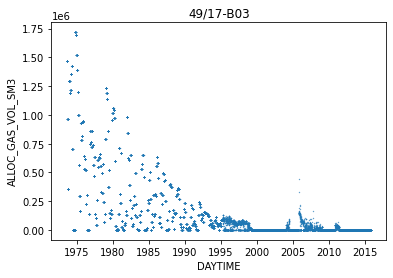

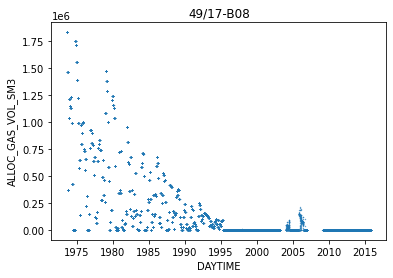

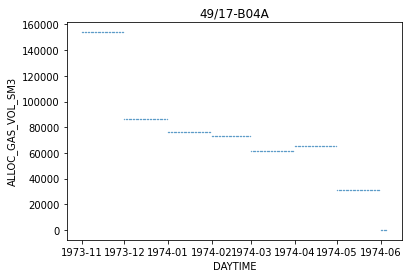

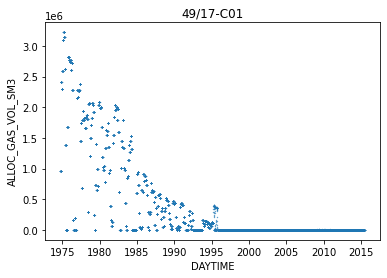

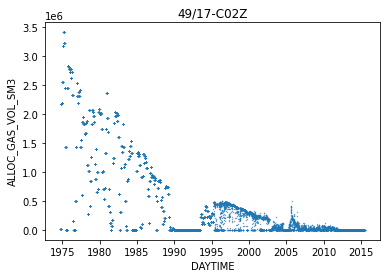

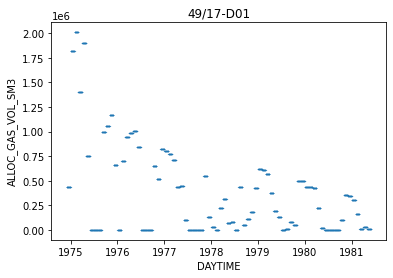

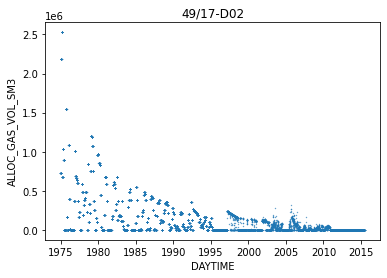

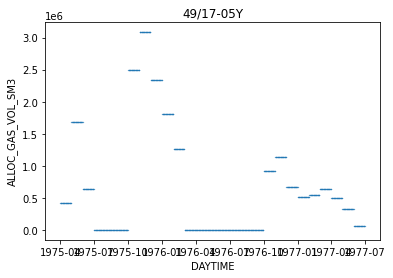

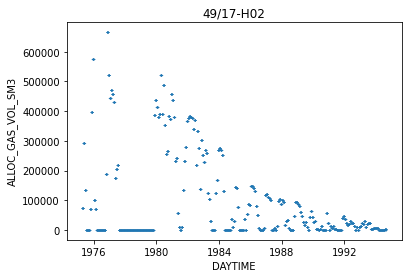

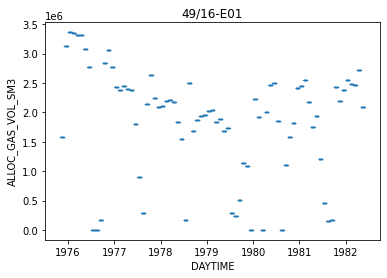

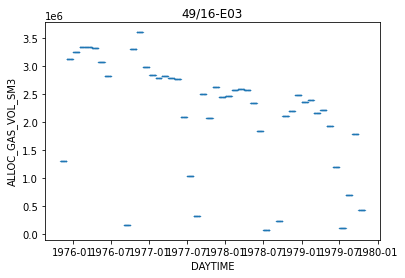

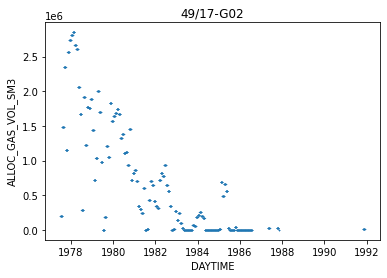

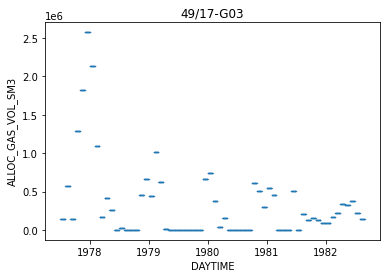

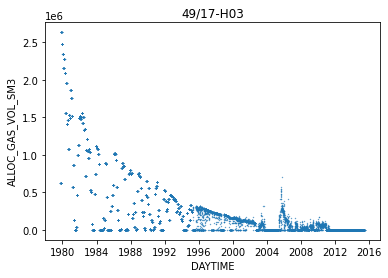

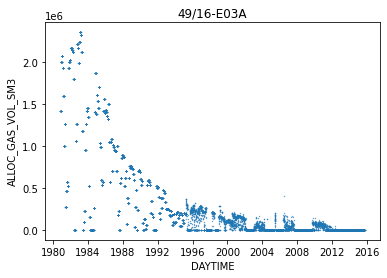

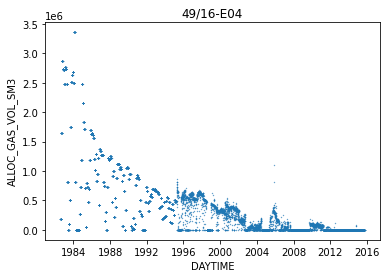

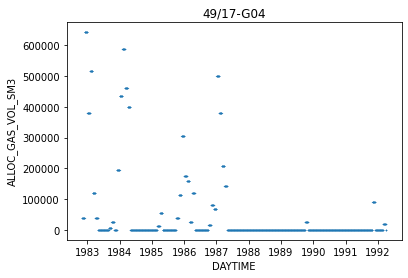

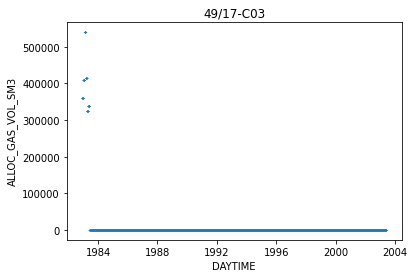

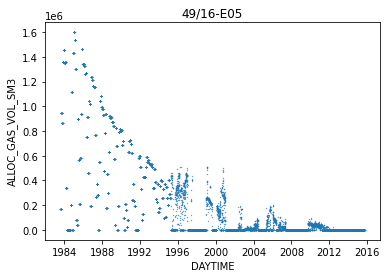

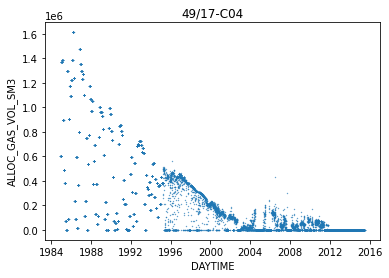

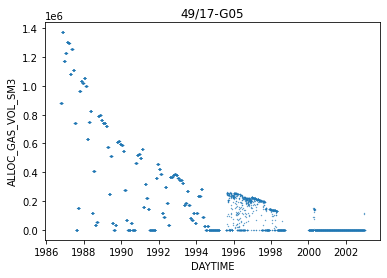

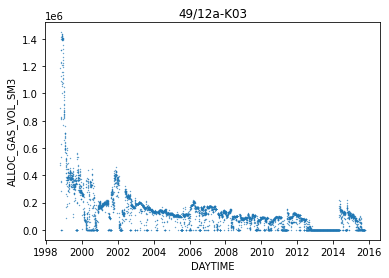

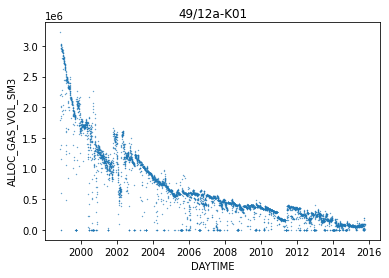

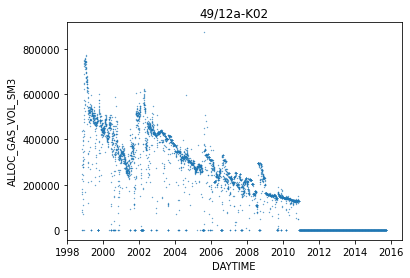

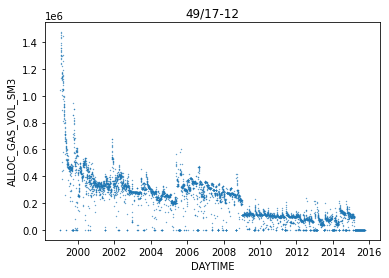

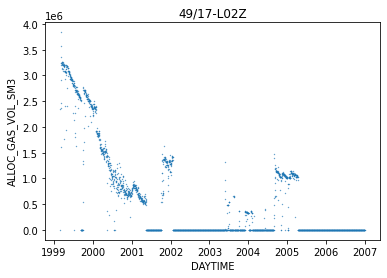

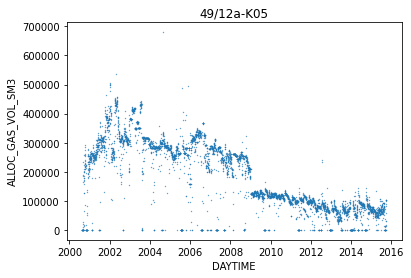

In [ ]:
Plots.wells(data)


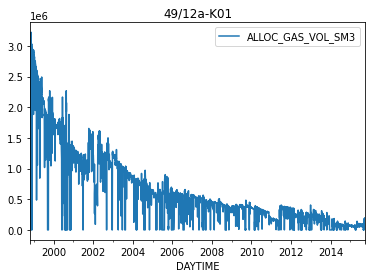

In [ ]:
# Выберем конкретную скважину для прогноза ее дебита
wellname = '49/12a-K01'
df = data[data['WELLNAME'] == wellname]

# Выделим ключевые признаки время и дебит
df = df[['DAYTIME', 'ALLOC_GAS_VOL_SM3']].set_index('DAYTIME')
df.plot(title = wellname)
plt.show()


Чтобы проверить, в хронологическом ли порядке расположены даты и время, используем атрибут индекса таблицы `is_monotonic`. Если порядок соблюдён, атрибут вернёт True, если нет — False. Также проверим количество пропусков и при необходимости заменим их нулевыми значениями, предположив, что в эти дни скважина была остановлена, например, для проведения технологических операций.


In [ ]:
print(df.index.is_monotonic)
print('Количество пропущенных значений: ', df.isna().sum())
df = df.fillna(0)


True
Количество пропущенных значений:  ALLOC_GAS_VOL_SM3    12
dtype: int64


Из графика видно, что наш ряд имеет небольшое кол-во выбросов, которые влияют на разброс. Кроме того анализировать дебит газа за каждый день не совсем верно, т.к., например, имеют место периодические остановки добычи для проведения различных технологических операций на скважине. Поэтому есть смысл перейти к недельному интервалу и среднему значению дебита на нем, это избавит нас от выбросов и уменьшит колебания нашего ряда. В pandas для этого есть удобная функция resample(), в качестве параметров ей передается период округления и аггрегатная функция.


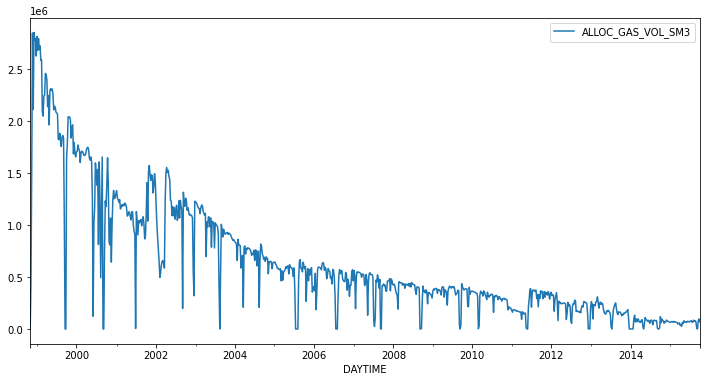

In [ ]:
df = df.resample('W').mean()
df.plot(figsize=(12,6))
plt.show()


В модуле `tsa.seasonal` (от англ. time series analysis) библиотеки `statsmodels` есть функция `seasonal_decompose()` . Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.


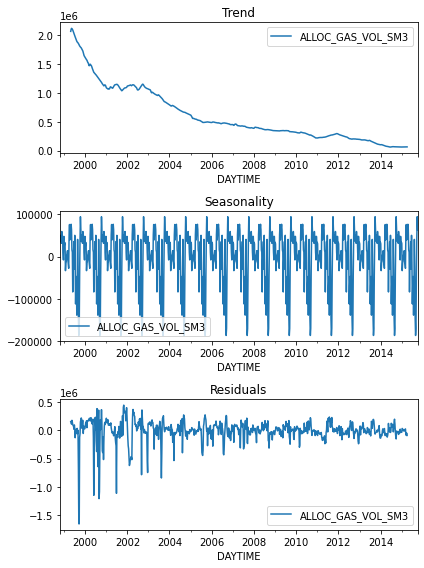

In [ ]:
Plots.seasonal_decomposition(df)


Временной ряд имеет тренд, характеризующий падение добычи газа со временем вследствие падения пластового давления по мере отборов газа из продуктивного пласта. Также выявлена сезонность с периодом 1 раз в год, что наиболее вероятно связано с периодическими ежегодными плановыми работами на скважине (ремонт, замена оборудования и пр.). Остаток показывает нерегулярную (не описываемую трендом или сезонностью) составляющую исходного ряда в начальный период работы скважины, что может объясняться подбором оптимальных параметров работы скважины в системе разработки месторождения.

В статистике временной ряд описывается стохастическим процессом. Это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются. Стохастический процесс стационарный (англ. stationary stochastic process), если его распределение со временем не меняется. Например, к такому процессу относятся периодические колебания значений.

Как можно заметить данные дебита газа имеют тренд. Это означает, что временной ряд - не стационарный. При этом меняется как среднее, так и стандартное отклонение. Прогнозировать при этом сложнее, т.к. свойства ряда меняются слишком быстро.

Построим первую прогнозную модель - ARIMA, предварительно приведем ряд к стационарному виду.


Критерий Дики-Фуллера: p=0.003656


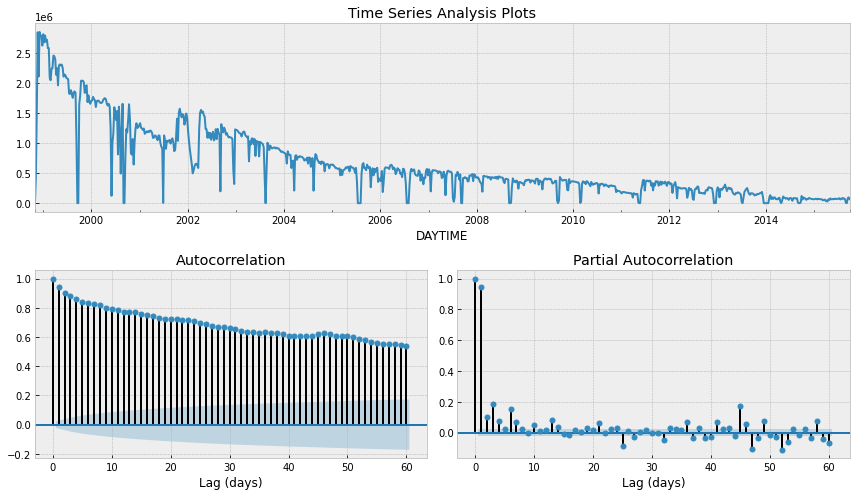

In [ ]:
Plots.tsplot(df['ALLOC_GAS_VOL_SM3'], lags=60)


Критерий Дики-Фуллера отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция показывает большое число значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, возьмем первые разности, чтобы привести ряд к стационарному виду.


Критерий Дики-Фуллера: p=0.000000


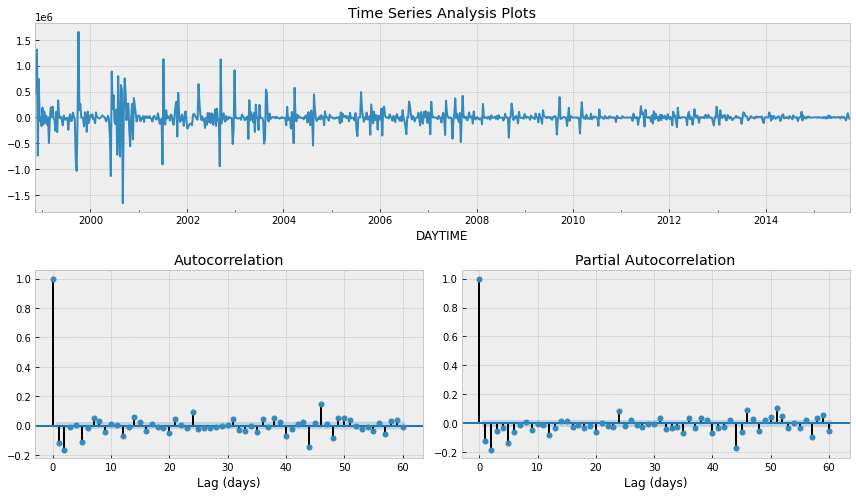

In [ ]:
df['ALLOC_GAS_VOL_SM3_diff'] = df['ALLOC_GAS_VOL_SM3'] - df['ALLOC_GAS_VOL_SM3'].shift(1)
Plots.tsplot(df['ALLOC_GAS_VOL_SM3_diff'][1:], lags=60)


Получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции подберем параметры для ARIMA модели.

## SARIMA

При близком рассмотрении модели ARIMA (Autoregressive Integrated Moving Average) можно выделить три компонента, составляющих данный акроним (Fulton, 2017):
* *AR: Autoregression* - характеризует зависимость наблюдаемого значения от отстающих (предшествующих) значений
* *I: Integrated* - характеризует скорость изменения наблюдаемых значений путем вычитания текущего наблюдаемого значения из значения на предшествующем шаге, чтобы сделать временной ряд стационарным
* *MA: Moving Average* - характеризует зависимость между наблюдением и остаточной ошибкой из модели скользящего среднего, применяемой к предшествующим наблюдениям.

Общий вид модели ARIMA (с учетом сезонности):

$$SARIMA(p,d,q)(P,D,Q)_s$$

где $p$ — число отстающих значений ряда, включенных в модель (порядок авторегрессии) \
$d$ — количество раз, когда брали разность наблюдаемых и отстающих значений (степень разности) \
$q$ — число отстающих значений, которые прибавляются или вычитаются из наблюдаемого значения (порядок скользящего среднего) \
$P$ — порядок сезонной авторегрессии \
$D$ — степень сезонной разности \
$Q$ — порядок сезонного скользящего среднего \
$s$ — сезонность (в нашем случае при ежегодной сезонности с недельным интервалом это значение составит 52)

Определим параметры $p, d, q$, после чего определим порядок сезонных составляющих $P,D,Q$.

Параметр *d* есть и он равет 1, осталось определить *p* и *q*. Для их определения нам надо изучить авторкорреляционную (*ACF*) и частную автокорреляционную (*PACF*) функции для ряда первых разностей.
*ACF* поможет нам определить *q*, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
*PACF* поможет нам определить *p*, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

После изучения коррелограммы *PACF* можно сделать вывод, что *p = 5*, т.к. на ней только 5 лаг сильно отличен от нуля. По коррелограмме *ACF* можно увидеть, что *q = 5*, т.к. после лага 5 значении функций резко падают.

Теперь перейдем к сезонным составляющим. В нашем случае, при сезонности 52, в лаге 52 параметры P и Q равны 0.
В результате наших исследований мы получили модель 

$$SARIMA(5,1,5)
(0,1,0)_{52}$$


In [ ]:
# Возьмем прогнозный период за последние 2 года (104 недели)
predict_period = 104

# Выделим обучающую и тестовую выборки
df_train = df['ALLOC_GAS_VOL_SM3'][:-predict_period]
df_test = df['ALLOC_GAS_VOL_SM3'][-predict_period:]

model_arima = SARIMAX(df_train,
                      order=(5, 1, 5),
                      seasonal_order=(0, 1, 0, 52)).fit()

print(model_arima.summary())


                                 Statespace Model Results                                 
Dep. Variable:                  ALLOC_GAS_VOL_SM3   No. Observations:                  780
Model:             SARIMAX(5, 1, 5)x(0, 1, 0, 52)   Log Likelihood              -10097.452
Date:                            Fri, 10 Dec 2021   AIC                          20216.905
Time:                                    14:38:22   BIC                          20267.383
Sample:                                11-01-1998   HQIC                         20236.383
                                     - 10-06-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4925      0.151     -3.263      0.001      -0.788      -0.197
ar.L2         -1.0437      0.155   

Проверим остатки модели:

Критерий Дики-Фуллера: p=0.000000


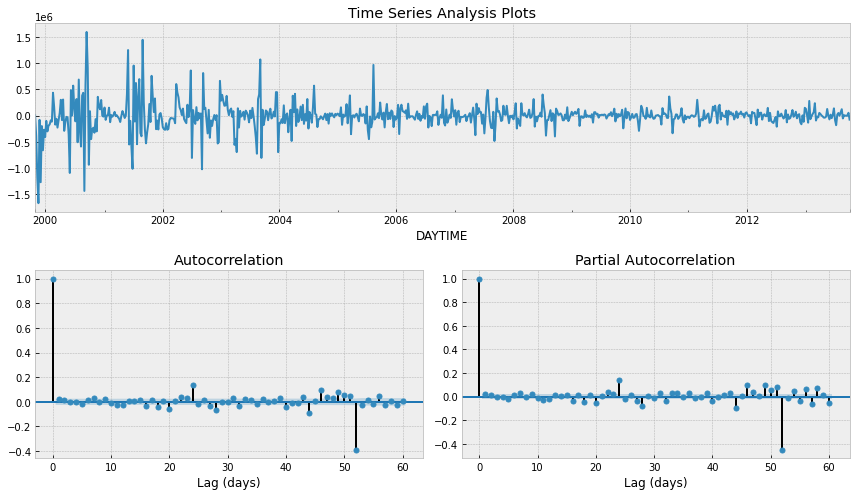

In [ ]:
Plots.tsplot(model_arima.resid[52:], lags=60)


Остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели.

Построим графики истинных и прогнозных значений, а также проведем оценку качества с помощью метрик MAE и MAPE.

(733773.0, 735964.0)

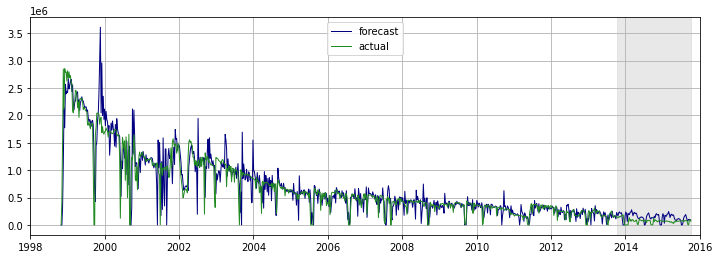

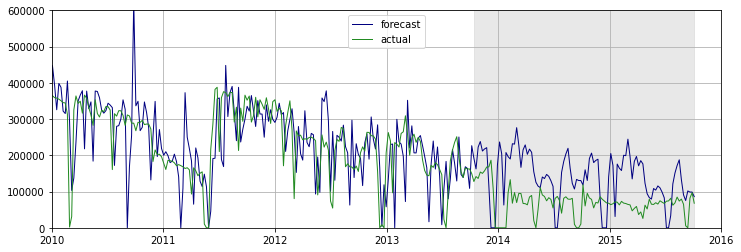

In [ ]:
# Выделим истинные и прогнозные значения для графиков
actual = df['ALLOC_GAS_VOL_SM3']
forecast = model_arima.fittedvalues.append(model_arima.forecast(steps=predict_period))

# Дебит скважины не может быть отрицательным
# Заменим отрицательные прогнозные значения на 0
forecast[forecast <= 0] = 0

# Дополним исходный датафрейм прогнозными значениями
df_fc_arima = pd.concat([df['ALLOC_GAS_VOL_SM3'], forecast], axis=1, keys=['actual', 'forecast']).astype('float64')

# Построим график (полный)
Plots.forecast_plot(actual, forecast, predict_period)

# Построим график (по целевому участку)
Plots.forecast_plot(actual, forecast, predict_period)
plt.ylim(0, 6e05)
plt.xlim(pd.Timestamp(2010, 1, 1), pd.Timestamp(2016, 1, 1))


Среднее значение ежемесячной ошибки по годам: 159460.97


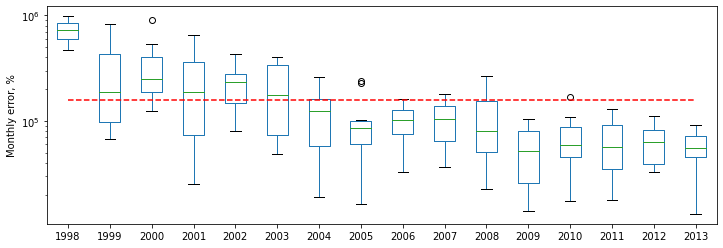

In [ ]:
# Построим диаграммы размаха метрики MAE для обучающей выборки
Plots.boxplot(df_fc_arima[:-predict_period], mae)


Среднее значение ежемесячной ошибки по годам: 0.21


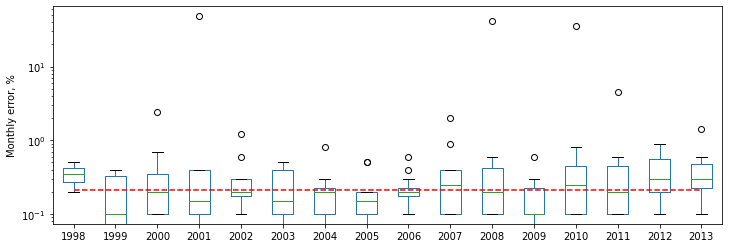

In [ ]:
# Построим диаграммы размаха для метрики MAPE для обучающей выборки
Plots.boxplot(df_fc_arima[:-predict_period], mape)


Среднее значение ежемесячной ошибки по годам: 72585.07


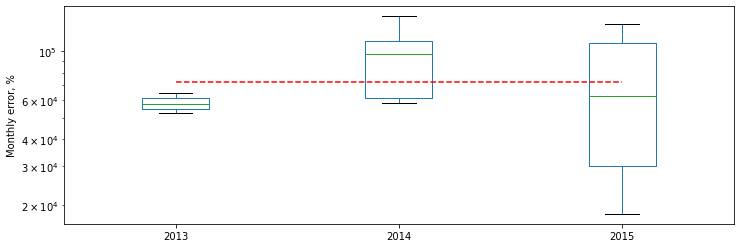

In [ ]:
# Построим диаграммы размаха метрики MAE для тестовой выборки
Plots.boxplot(df_fc_arima[-predict_period:], mae)


Среднее значение ежемесячной ошибки по годам: 1.05


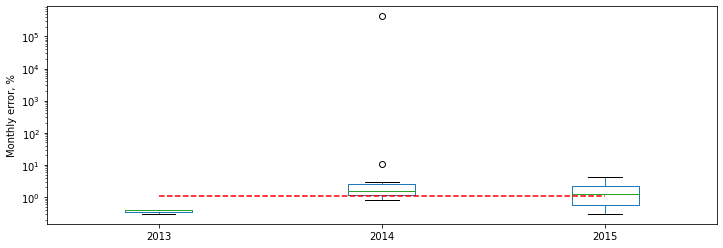

In [ ]:
# Построим диаграммы размаха метрики MAPE для тестовой выборки
Plots.boxplot(df_fc_arima[-predict_period:], mape)


(734503.0, 736695.0)

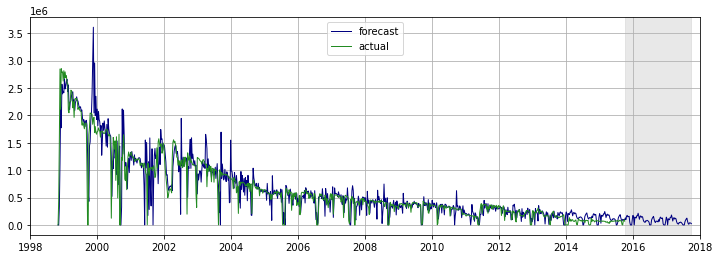

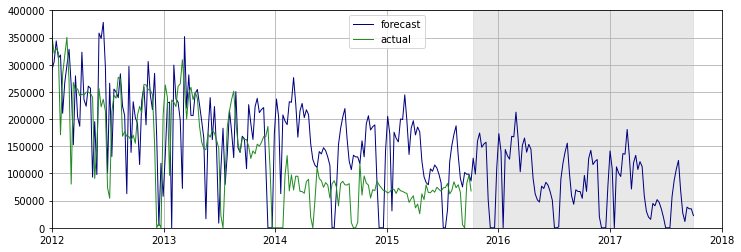

In [ ]:
# Прогноз на следующие 2 года (вне исходных данных)
actual = df['ALLOC_GAS_VOL_SM3']
forecast = model_arima.fittedvalues.append(model_arima.forecast(steps=2*predict_period))
forecast[forecast <= 0] = 0

# Построим график (полный)
Plots.forecast_plot(actual, forecast, predict_period)

# Построим график (по целевому участку)
Plots.forecast_plot(actual, forecast, predict_period)
plt.ylim(0, 4e05)
plt.xlim(pd.Timestamp(2012, 1, 1), pd.Timestamp(2018, 1, 1))

### Facebook Prophet

https://research.fb.com/prophet-forecasting-at-scale/

Библиотека Prophet - это модель, состоящая из следующих компонент:
$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$
* Сезонные компоненты $s(t)$ отвечают за моделирование периодических изменений, связанных с недельной и годовой сезонностью. Недельная сезонность моделируется с помощью dummy variables. Добавляются 6 дополнительных признаков, например, [monday, tuesday, wednesday, thursday, friday, saturday], которые принимают значения 0 и 1 в зависимости от даты. Признак sunday, соответствующий седьмому дню недели, не добавляют, потому что он будут линейно зависеть от других дней недели и это будет влиять на модель.
Годовая же сезонность моделируется рядами Фурье.
* Тренд $g(t)$ — это кусочно-линейная или логистическая функция. Логистическая функция вида
$$g(t) = \frac{C}{1+exp(-k(t-b))}$$ 
позволяет моделировать рост с насыщением, когда при увеличении показателя снижается темп его роста (например, рост аудитории приложения или сайта). \
Библиотека приспособлена выбирать оптимальные точки изменения тренда. Но их также можно задать и вручную (например, если известны даты релизов новой функциональности, которые сильно повлияли на ключевые показатели).
* Компонента $h(t)$ отвечает за заданные пользователем аномальные дни, в том числе и нерегулярные, такие как, например, Black Fridays.
* Ошибка $\epsilon_{t}$ содержит информацию, которая не учтена моделью.

In [ ]:
#Создадим и обучим модель
model_prophet = Prophet()
model_prophet.fit(pd.DataFrame({'ds': df_train.index, 'y': df_train}).reset_index(drop=True))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
periods = 724
future = model_prophet.make_future_dataframe(periods=periods)
future.tail()


,ds
1499,2015-09-26
1500,2015-09-27
1501,2015-09-28
1502,2015-09-29
1503,2015-09-30


In [ ]:
prediction = model_prophet.predict(future)
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1499,2015-09-26,-65408.940827,-387036.211664,250620.769176
1500,2015-09-27,-48392.242984,-351701.927104,267759.313067
1501,2015-09-28,-30342.438881,-341189.052703,283989.496808
1502,2015-09-29,-11532.985736,-315112.507762,290477.991602
1503,2015-09-30,7746.894673,-311102.230383,331541.386264


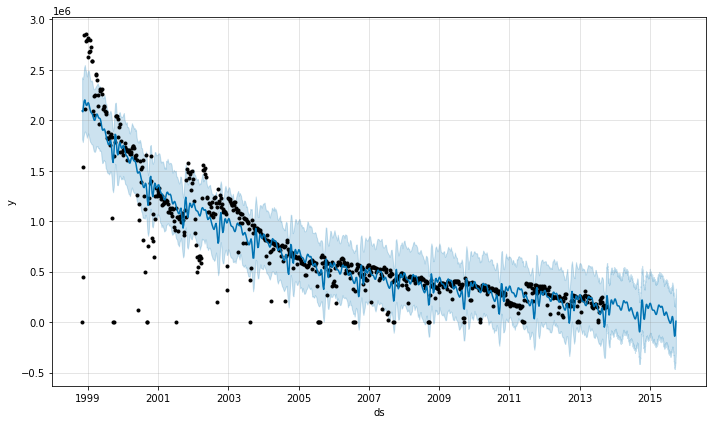

In [ ]:
fig1 = model_prophet.plot(prediction)


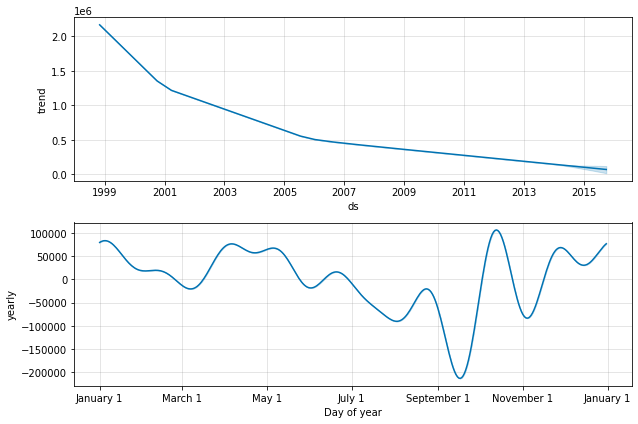

In [ ]:
fig2 = model_prophet.plot_components(prediction)


(733773.0, 735964.0)

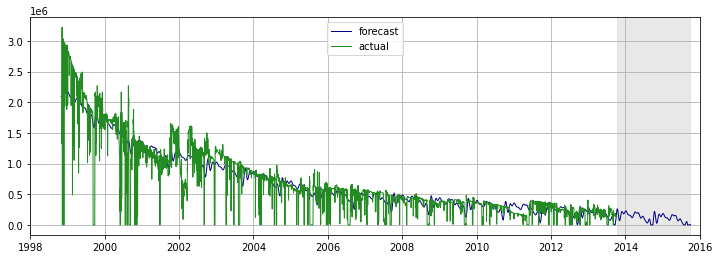

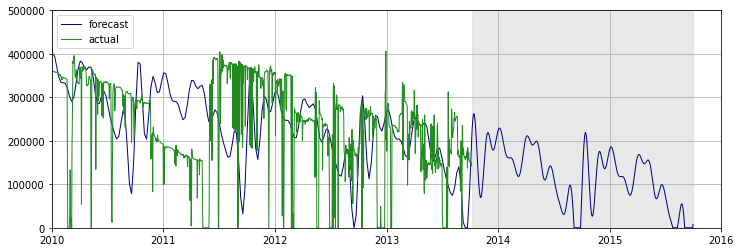

In [ ]:
# Выделим истинные и прогнозные значения для графиков
actual = data[(data['WELLNAME'] == wellname) & 
     (data['DAYTIME'] < '2013-10-07')][['DAYTIME', 'ALLOC_GAS_VOL_SM3']].set_index('DAYTIME')
forecast = pd.DataFrame(prediction['yhat']).set_index(prediction['ds'])
forecast[forecast <= 0] = 0

# Построим график (полный)
Plots.forecast_plot(actual, forecast, periods)

# Построим график (по целевому участку)
Plots.forecast_plot(actual, forecast, periods)
plt.ylim(0, 5e05)
plt.xlim(pd.Timestamp(2010, 1, 1), pd.Timestamp(2016, 1, 1))

(733773.0, 735964.0)

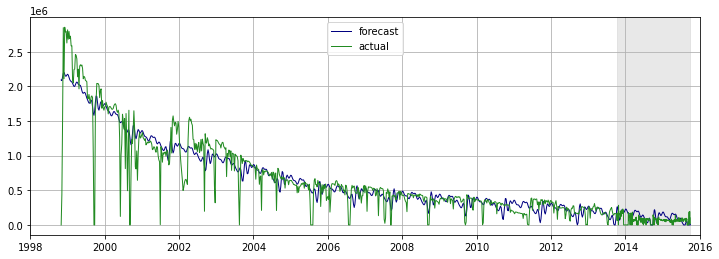

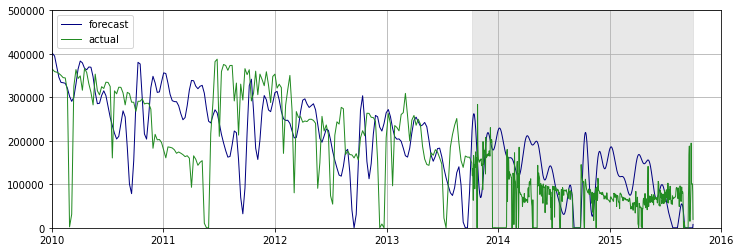

In [ ]:
# Выделим истинные и прогнозные значения для графиков
actual_filtered = data[(data['WELLNAME'] == wellname) & 
     (data['DAYTIME'] >= '2013-10-07') & 
     (data['DAYTIME'] <= '2015-10-06')][['DAYTIME', 'ALLOC_GAS_VOL_SM3']].set_index('DAYTIME')

actual = pd.DataFrame(df_train).append(pd.DataFrame(actual_filtered))
forecast = prediction[['ds', 'yhat']].set_index('ds')
forecast[forecast <= 0] = 0

# Дополним исходный датафрейм прогнозными значениями
df_fc_prophet = pd.concat([actual, forecast], axis=1, ignore_index=True).astype('float64')
df_fc_prophet.rename(columns={0: 'actual', 1: 'forecast'}, inplace=True)

# Построим график (полный)
Plots.forecast_plot(actual, forecast, periods)

# Построим график (по целевому участку)
Plots.forecast_plot(actual, forecast, periods)
plt.ylim(0, 5e05)
plt.xlim(pd.Timestamp(2010, 1, 1), pd.Timestamp(2016, 1, 1))

Среднее значение ежемесячной ошибки по годам: 145771.83


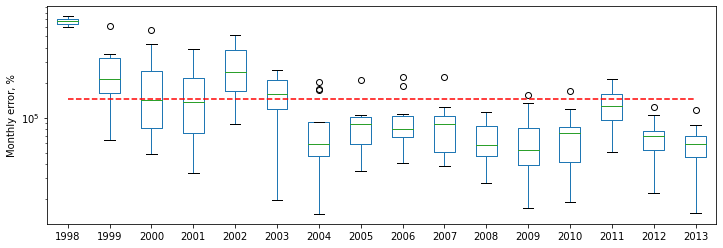

In [ ]:
# Построим диаграммы размаха метрики MAE для обучающей выборки
Plots.boxplot(df_fc_prophet[:-periods], mae)


Среднее значение ежемесячной ошибки по годам: 0.23


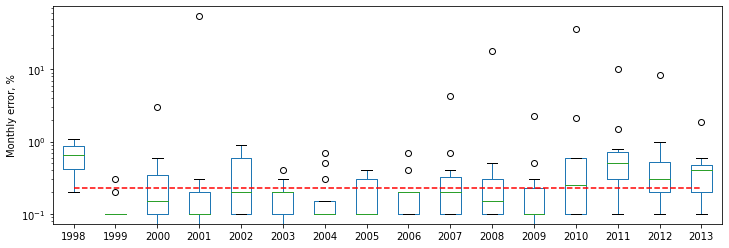

In [ ]:
# Построим диаграммы размаха метрики MAPE для обучающей выборки
Plots.boxplot(df_fc_prophet[:-periods], mape)


Среднее значение ежемесячной ошибки по годам: 52159.27


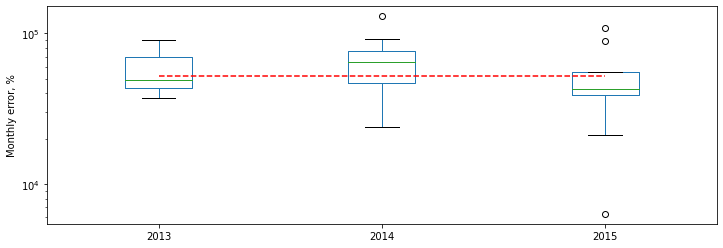

In [ ]:
# Построим диаграммы размаха метрики MAE для тестовой выборки
Plots.boxplot(df_fc_prophet[-periods:], mae)

Среднее значение ежемесячной ошибки по годам: 0.9


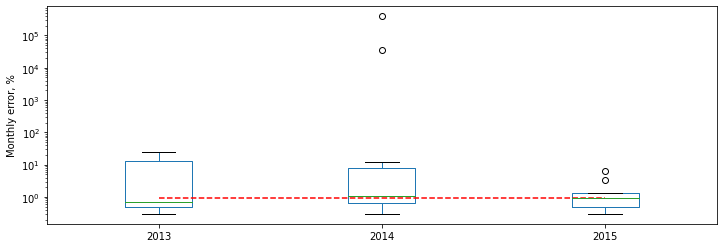

In [ ]:
# Построим диаграммы размаха метрики MAPE для тестовой выборки
Plots.boxplot(df_fc_prophet[-periods:], mape)

### XGBoost
XGBoost (Extreme Gradient Boosting) представляет собой эффективную реализацию алгоритма машинного обучения стохастического повышения градиента для задач классификации и регрессии.

XGBoost также можно использовать для прогнозирования временных рядов, хотя для этого требуется, чтобы набор данных временных рядов сначала был преобразован в задачу контролируемого обучения. Это также требует использования специальной техники для оценки модели, называемой пошаговой проверкой.

In [ ]:
# Подготовим данные временного ряда под задачу обучения с учителем

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	
  # последовательность на вход (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	
  # последовательность на выход - прогноз (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	
  # Объединим колонки
	agg = pd.concat(cols, axis=1)
	
  # Исключим из датасета NaN значения
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 

In [ ]:
lag = 6
train = series_to_supervised(df_train.to_list(), n_in=lag)
test = series_to_supervised(df_test.to_list(), n_in=lag)
X_train, y_train, X_test, y_test = train[:, :-1], train[:, -1], test[:, :-1], test[:, -1]
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xgb.fit(X_train, y_train)


XGBRegressor(n_estimators=1000, objective='reg:squarederror')

(733773.0, 735964.0)

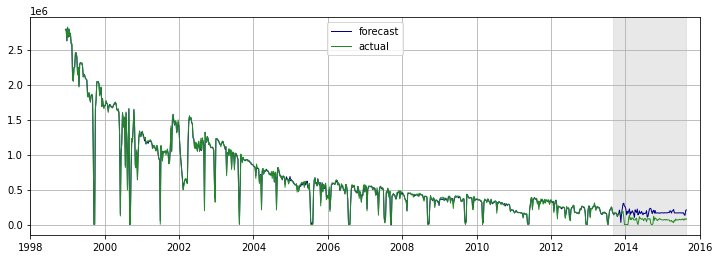

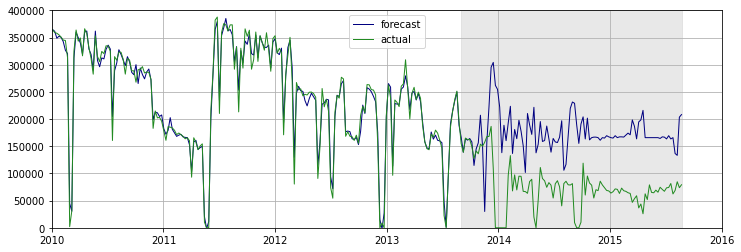

In [ ]:
# Выделим истинные и прогнозные значения для графиков
actual = df['ALLOC_GAS_VOL_SM3'][lag:-lag]
forecast = pd.Series(model_xgb.predict(np.concatenate((X_train, X_test))))

# Дополним исходный датафрейм прогнозными значениями
df_fc_xgb = pd.concat([pd.Series(actual.index), pd.Series(actual.values), forecast],
                  axis=1, keys=['DAYTIME', 'actual', 'forecast']).set_index('DAYTIME')
df_fc_xgb.astype('float64')

# Построим график (полный)
Plots.forecast_plot(df_fc_xgb.actual, df_fc_xgb.forecast, predict_period)

# Построим график (по целевому участку)
Plots.forecast_plot(df_fc_xgb.actual, df_fc_xgb.forecast, predict_period)
plt.ylim(0, 4e05)
plt.xlim(pd.Timestamp(2010, 1, 1), pd.Timestamp(2016, 1, 1))


Среднее значение ежемесячной ошибки по годам: 10913.78


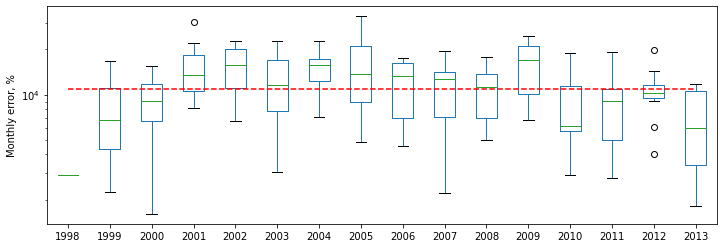

In [ ]:
# Построим диаграммы размаха метрики MAE для обучающей выборки
Plots.boxplot(df_fc_xgb[:-X_test.shape[0]], mae)

Среднее значение ежемесячной ошибки по годам: 0.0


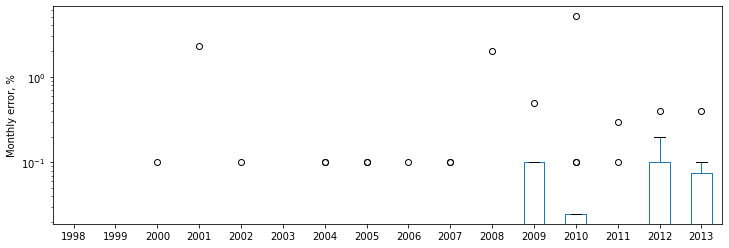

In [ ]:
# Построим диаграммы размаха метрики MAPE для обучающей выборки
Plots.boxplot(df_fc_xgb[:-X_test.shape[0]], mape)

Среднее значение ежемесячной ошибки по годам: 80262.07


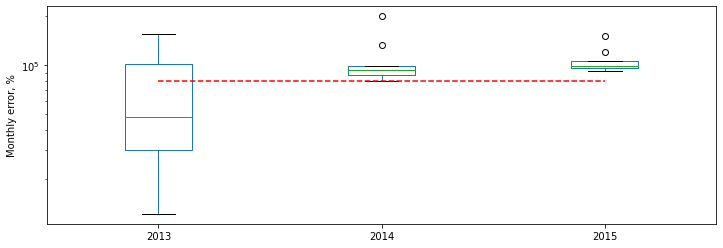

In [ ]:
# Построим диаграммы размаха метрики MAE для тестовой выборки
Plots.boxplot(df_fc_xgb[-X_test.shape[0]:], mae)

Среднее значение ежемесячной ошибки по годам: 1.02


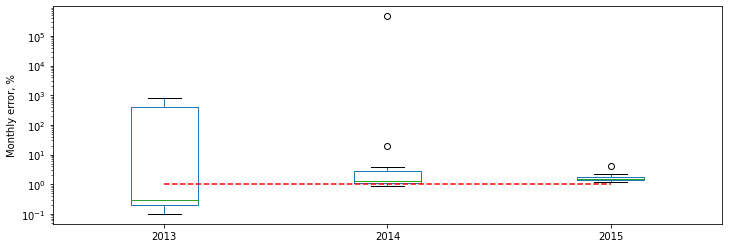

In [ ]:
# Построим диаграммы размаха метрики MAPE для тестовой выборки
Plots.boxplot(df_fc_xgb[-X_test.shape[0]:], mape)

### Выводы и заключение

(729390.0, 735964.0)

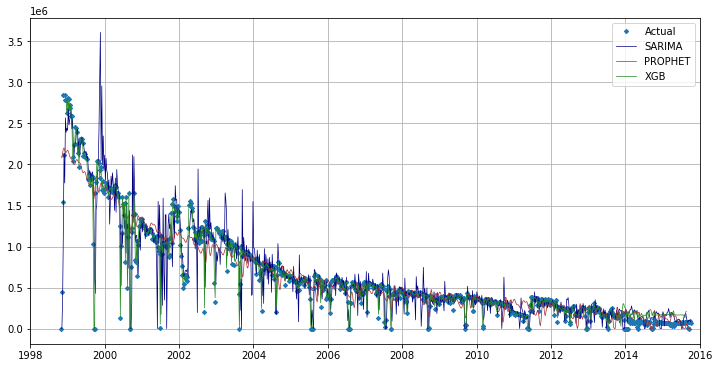

In [ ]:
Plots.results()
plt.xlim(pd.Timestamp(df_fc_arima.index[0].year, 1, 1), pd.Timestamp(df_fc_arima.index[-1].year+1, 1, 1))


(0.0, 700000.0)

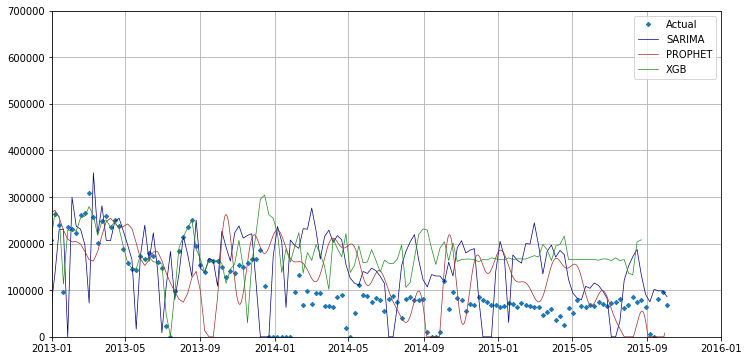

In [ ]:
Plots.results()
plt.xlim(pd.Timestamp(df_fc_arima.index[-1].year-2, 1, 1), pd.Timestamp(df_fc_arima.index[-1].year+1, 1, 1))
plt.ylim(0, 7e05)


In [ ]:
pd.DataFrame({'Model': ['SARIMA', 'Facebook Prophet', 'XGBoost'],
              'MAE': [72585.07, 52159.27, 80262.07],
              'MAPE': [1.05, 0.9, 1.02]})


,Model,MAE,MAPE
0,SARIMA,72585.07,1.05
1,Facebook Prophet,52159.27,0.90
2,XGBoost,80262.07,1.02


Лучшее качество по метрикам MAE и MAPE в решении задачи прогнозирования дебита газовой скважины показала модель Facebook Prophet.

Список литературы:\
Arps, J.J. 1945. Analysis of Decline Curves. Published in Petroleum Transactions, AIME, 160 (1945): 228 –247.\
Duong, A. 2010. An Unconventional Rate Decline Approach for Tight and Fracture-Dominated Gas Wells. Paper CSUG/SPE 137748 presented at the 2010 Canadian Unconventional Resources and International Petroleum Conference, Calgary, Alberta, Canada, 19-21 October.\
Ilk, D., Rushing, J. A. and Blasingame, T.A. 2008. Exponential vs. Hyperbolic Decline in Tight Gas Sands Understanding the Origin and Implications for Reserve Estimates Using Arps’ Decline Curves. Paper SPE 116731 presented at the 2008 SPE Annual Technical Conference and Exhibition, Denver, CO, USA, 21-24 September.\
Sean J. Taylor, Ben Letham :: Facebook Prophet – forecasting at scale :: 2017\
C. I. Noshi, “Application of Data Science and Machine Learning Algorithms for ROP Optimization in West Texas: Turning Data into Knowledge,” Offshore Technology Conference, Houston, TX, 2019.\
A. Marana, J. Papa, M. V. Ferreira, K. Miura, and F. A. Torres, “An Intelligent System To Detect Drilling Problems Through Drilled-CuttingsReturn Analysis,” IADC/SPE Drilling Conference and Exhibition, New Orleans, LA, 2010.\
S. Tandon, “Integrating Machine Learning in Identifying Sweet Spots in Unconventional Formations,” SPE Western Regional Meeting, San Jose, CA, 2019\
S. Vallabhaneni, R. Saraf, and S. Priyadarshy, “Machine-LearningBased Petrophysical Property Modeling,” SPE Europec at 81st EAGE Conference and Exhibition, London, England, UK, 2019.\
F. A. Anifowose, “Ensemble Machine Learning: The Latest Development in Computational Intelligence for Petroleum Reservoir Characterization,” SPE Saudi Arabia Section Technical Symposium and Exhibition, Al-Khobar, Saudi Arabia, 2013.\
M. Pennel, J. Hsiung and V. Putcha, “Detecting Failures and Optimizing Performance in Artificial Lift Using Machine Learning Models,” SPE Western Regional Meeting, Garden Grove, CA, 2018.\
D. Castiniera, R. Toronyi, and N. Saleri, “Machine Learning and Natural Language Processing for Automated Analysis of Drilling and Completion Data,” SPE Kingdom of Saudi Arabia Annual Technical Symposium and Exhibition, Dammam, Saudi Arabia, 2018.\
A. Rastogi and A. Sharma, “Quantifying the Impact of Fracturing Chemicals on Production Performance Using Machine Learning,” SPE Liquids-Rich Basins Conference—North America, Odessa, TX, 2019.\
D. Fu, “Unlocking Unconventional Reservoirs With Data Analytics, Machine Learning, and Artificial Intelligence,” Journal of Petroleum Technology, pp. 14–15, January 2019.\
S. Mohaghegh, “How Does the Use of Artificial Intelligence and Machine Learning Differ for Conventional vs. Unconventional Plays?,” Data Science and Digital Engineering in Upstream Oil and Gas, October 7, 2019\
J. Sun, X. Ma and M. Kazi, “Comparison of Decline Curve Analysis DCA with Recursive Neural Networks RNN for Production Forecast of Multiple Wells,” SPE Western Regional Meeting, Garden Grove, CA, 2018.